In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nn import Layer, FeedForwardNN, WeightInitializationOption, WeightInitializer, Activation
from optimizers import RMSProp, StochasticGradientDescent
from metrics import mean_squared_error_loss
from sklearn.model_selection import train_test_split


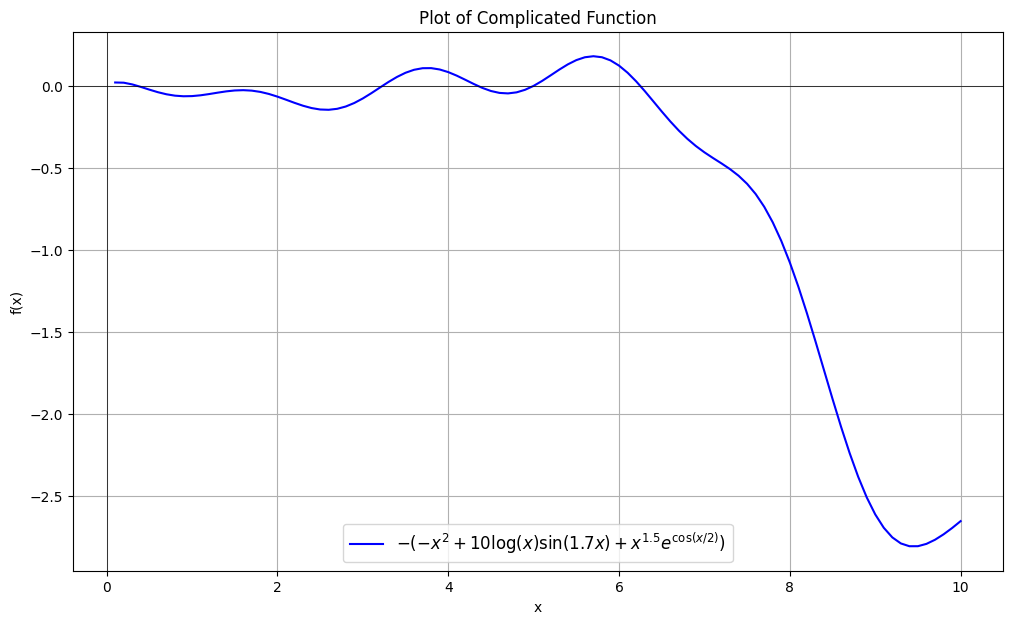

In [2]:
def complicated_function(x):
    
    return -(-x**2 + 5 * np.log(x*2) * np.sin(x*3) + x ** 1.7 * 3*np.exp(np.cos(x/1.5))) / 100


x_values = np.linspace(0.1, 10, 100)

# Calculate the corresponding y values
y_values = complicated_function(x_values)

# Plot the function
plt.figure(figsize=(12, 7)) # Set the figure size for better readability
plt.plot(x_values, y_values , label=r'$-(-x^2 + 10 \log(x) \sin(1.7x) + x^{1.5} e^{\cos(x/2)})$', color='blue')
plt.title('Plot of Complicated Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True) # Add a grid for easier reading of values
plt.legend(fontsize=12) # Show the label and increase font size for readability
plt.axhline(0, color='black', linewidth=0.5) # Add a horizontal line at y=0
plt.axvline(0, color='black', linewidth=0.5) # Add a vertical line at x=0
plt.show()

In [3]:
def plot_gradients_histogram(model):
    """
    Plots histogram of gradient values for each layer in the model.
    Assumes each layer has parameters with .grad populated.
    """

    for idx, layer in enumerate(model.layers):
        grads = []

        # Collect gradients from weights and biases
        for neuron in layer.neurons:
            for w in neuron.weights:  # neuron.w is list of weights (Value objects)
                if w.grad is not None:
                    grads.append(w.grad)
            if neuron.bias.grad is not None:
                grads.append(neuron.bias.grad)

        # Flatten and plot histogram
        if grads:
            plt.figure(figsize=(4, 5))
            plt.hist(grads, bins=50, color='blue', alpha=0.7)
            plt.title(f"Layer {idx + 1} Gradient Histogram")
            plt.xlabel("Gradient Value")
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No gradients found in layer {idx + 1}")

In [4]:
X_data_reshaped = x_values.reshape(-1, 1) # Reshape x_values to be a 2D array for train_test_split

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_data_reshaped, y_values, test_size=0.1, random_state=42
)

# Convert to list of lists for X and list for y, as expected by FeedForwardNN
X_train = X_train_np.tolist()
y_train = y_train_np.tolist()

X_val = X_val_np.tolist()
y_val = y_val_np.tolist()


In [5]:
track_epochs = [1, 2,  5, 20, 50, 100, 150, 200, 250]

In [ ]:

model = FeedForwardNN(
    layers=[
        Layer(n_input=1,  # Single input feature 'x'
              n_output=16, 
              activation=Activation.RELU,
              initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=np.sqrt(1/(16 + 1)))
             ),
        Layer(n_input=16, # Input to this layer is output of previous layer
              n_output=8, 
              activation=Activation.TANH,
              initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=np.sqrt(1/(16 + 8)))
             ),
        Layer(n_input=8, # Input to this layer is output of previous layer
              n_output=8, 
              activation=Activation.RELU,
              initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=np.sqrt(1/(4 + 8)))),
        Layer(n_input=8, # Input to this layer is output of previous layer
              n_output=1, 
              activation=Activation.LINEAR,
              initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=np.sqrt(1/(4 + 1)))),
              ]
)

# 3. Choose Optimizer and Loss
params = model.parameters()
learning_rate = 0.003
optimizer =  RMSProp(parameters=params , lr=learning_rate, beta=0.95)
loss_fn = mean_squared_error_loss # Appropriate for regression
epochs = 100 # More epochs might be needed for complex functions
batch_size = 16 # Batch size


model.fit(
    X_train=X_train,
    y_train=y_train,
    optimizer=optimizer,
    loss=loss_fn,
    epochs=epochs,
    batch_size=batch_size,
    metric="mse",
    X_val=X_val,
    y_val=y_val,
    display_each_n_step=5)


plot_gradients_histogram(model)

2025-07-15 21:48:15.334 | INFO     | nn:fit:414 - Epoch 1/100  train_loss=1.4387  mse: 1.4387013515095615    val_loss=0.3132  val_mse=0.3132
2025-07-15 21:48:18.930 | INFO     | nn:fit:414 - Epoch 5/100  train_loss=0.4111  mse: 0.41112617608110313    val_loss=0.1228  val_mse=0.1228
2025-07-15 21:48:23.790 | INFO     | nn:fit:414 - Epoch 10/100  train_loss=0.2431  mse: 0.2431422740992546    val_loss=0.1442  val_mse=0.1442
Epoch 11/100: 0it [00:00, ?it/s]

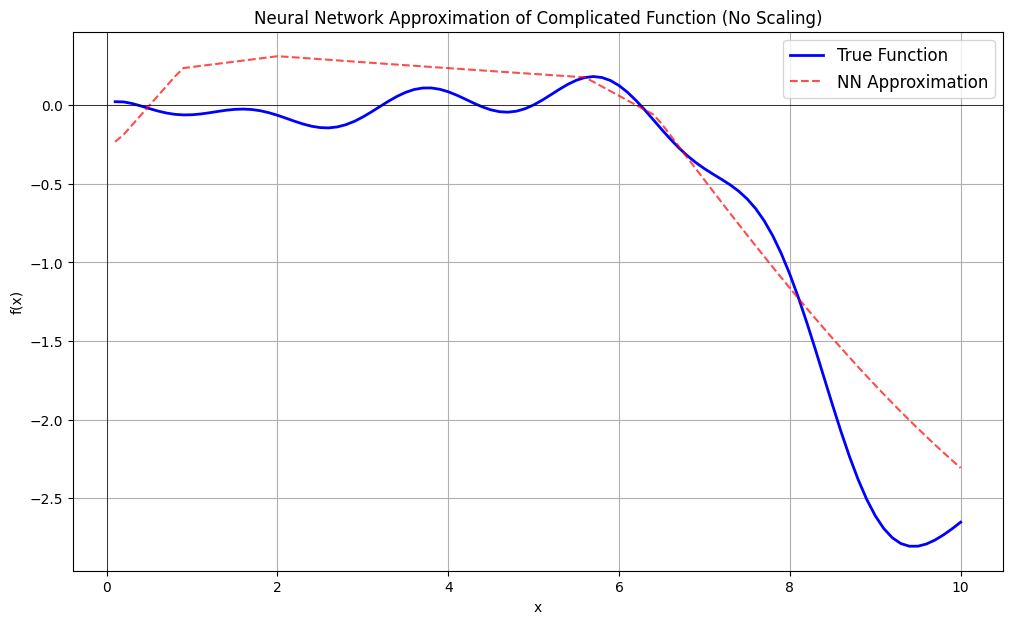

In [116]:
X_full_for_prediction = [[x] for x in x_values]
y_pred_values_nested = model.forward_batch(x=X_full_for_prediction)

# Extract the scalar value from the single output neuron
# The output of forward_batch is List[List[Value]], so we need to get the Value object
# from the inner list and then its .val attribute.
y_pred_np = np.array([val[0].val for val in y_pred_values_nested])


# Plotting
plt.figure(figsize=(12, 7))
plt.plot(x_values, y_values, label='True Function', color='blue', linewidth=2)
plt.plot(x_values, y_pred_np, label='NN Approximation', color='red', linestyle='--', alpha=0.7)
plt.title('Neural Network Approximation of Complicated Function (No Scaling)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend(fontsize=12)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()



# TORCH

Epoch 20/100 - Train Loss: 2.5201, Val Loss: 0.2484
Epoch 40/100 - Train Loss: 2.3304, Val Loss: 0.3216
Epoch 60/100 - Train Loss: 2.1139, Val Loss: 0.3316
Epoch 80/100 - Train Loss: 2.1519, Val Loss: 0.3136
Epoch 100/100 - Train Loss: 1.9367, Val Loss: 0.2853


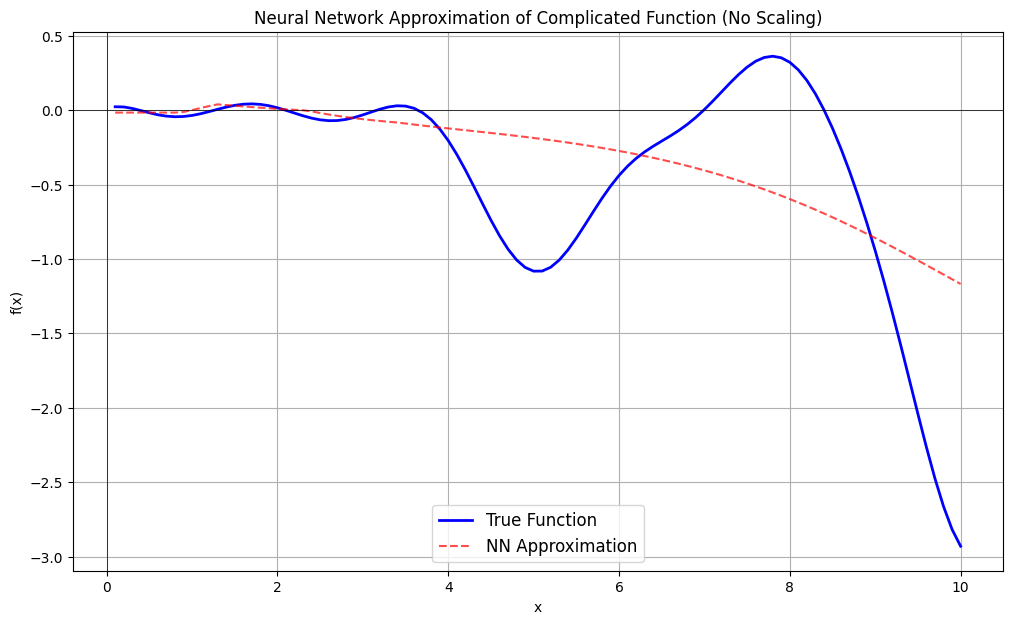

In [102]:
##TORCH

import torch
import torch.nn as nn
import torch.optim as optim


# Convert to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32).unsqueeze(1)

# 2. Define the model
class SimpleRegressor(nn.Module):
    def __init__(self):
        super(SimpleRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 8),
            nn.Tanh(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        return self.net(x)

torch_model = SimpleRegressor()

# 3. Training setup
criterion = nn.MSELoss()
optimizer = optim.RMSprop(torch_model.parameters(), lr=0.003, alpha=0.95)
epochs = 100
batch_size = 16
#LR SCHEDULER

# 4. Training loop
for epoch in range(epochs):
    perm = torch.randperm(X_train.size(0))
    epoch_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        indices = perm[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = torch_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 20 == 0:
        val_outputs = torch_model(X_val)
        val_loss = criterion(val_outputs, y_val).item()
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

# 5. Prediction and Plotting
X_full_for_prediction = torch.tensor(x_values.reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    y_pred = torch_model(X_full_for_prediction).squeeze().numpy()

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(x_values, y_values, label='True Function', color='blue', linewidth=2)
plt.plot(x_values, y_pred, label='NN Approximation', color='red', linestyle='--', alpha=0.7)
plt.title('Neural Network Approximation of Complicated Function (No Scaling)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend(fontsize=12)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()